# Modelado
Creacion e implementacion de modelos para predecir expecativa de ol de equipos.

## Preparacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg
import os

## Obtengo los datos ya filtrados

In [107]:
directorio_filtered = './filtered_data'

ruta_posiciones_filtered = os.path.join(directorio_filtered, 'data_posiciones_filtered.csv')
data_posiciones_filtered = pd.read_csv(ruta_posiciones_filtered)

ruta_goles_filtered = os.path.join(directorio_filtered, 'data_goles_filtered.csv')
data_goles_filtered = pd.read_csv(ruta_goles_filtered)

In [108]:
data_posiciones_filtered.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
56549,88159,129,125,454.799472,-152.005901,-50.865727,-78.404816,88.000000,2,1
16765,41385,67,48,-406.313842,42.163337,-97.940645,73.644403,50.150000,1,1
25080,49832,76,0,397.777892,-210.626171,-100.712589,8.749778,254.283333,0,1
38369,67016,98,92,-355.726021,-120.696936,36.121741,-49.264076,134.783333,1,1
40910,69591,102,99,-115.839167,-52.360000,95.583410,-96.137324,41.033333,1,1
11352,34086,58,48,163.756337,113.417580,-51.593726,121.420895,24.116667,2,1
31559,59925,92,91,-33.758580,-21.213452,139.266471,45.105868,100.033333,2,1


In [109]:
data_goles_filtered.sample(7)

,id,match_id,player_id,player_name,equipo,tick
122,311,99,97,Tom,Red,23.016667
53,226,66,48,"marco!""",Red,109.183333
168,368,124,122,respect,Red,43.783333
150,349,116,2,tnt,Red,144.733333
193,397,134,130,el tussi,Blue,19.116667
35,198,56,54,Puskas,Red,23.633333
165,365,123,122,respect,Blue,36.516667


## Etiquetado de datos
Etiqueto datos para entrenar y testear al modelo

In [110]:
# Agrupo los momentos
data_posiciones_grouped_entities = data_posiciones_filtered.groupby(['match_id', 'time']).size().reset_index(name='entities')

In [111]:
data_posiciones_grouped_filtered_labeled = data_posiciones_grouped_entities

data_posiciones_grouped_filtered_labeled['gol_1_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_2_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_3_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_4_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_5_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_6_ticks'] = 'none'

In [112]:
# Diccionario para acceso rápido a los goles por match_id
goles_dict = data_goles_filtered.groupby('match_id').apply(lambda x: x[['tick', 'equipo']].to_dict('records')).to_dict()

In [113]:
# Iterar sobre las filas de data_grouped_entities_7ents
for index, row in data_posiciones_grouped_filtered_labeled.iterrows():
    match_id = row['match_id']
    time = row['time']
    
    if match_id in goles_dict:
        goles = goles_dict[match_id]
        
        # Filtrar goles futuros a partir del tiempo actual
        futuros_goles = [gol for gol in goles if gol['tick'] > time]
        
        for offset in range(1, 7):  # Revisar para ticks 1, 2, 3, 4, 5 y 6
            gol_cercano = next((gol['equipo'] for gol in futuros_goles if gol['tick'] <= time + offset), 'none')
            col_name = f'gol_{offset}_ticks'
            data_posiciones_grouped_filtered_labeled.at[index, col_name] = gol_cercano

In [114]:
match_id_test = 141
data_posiciones_grouped_filtered_labeled_idtest = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['match_id'] == match_id_test]

# Configurar para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evita que las columnas se corten

data_posiciones_grouped_filtered_labeled_idtest

,match_id,time,entities,gol_1_ticks,gol_2_ticks,gol_3_ticks,gol_4_ticks,gol_5_ticks,gol_6_ticks
9221,141,0.6,7,none,none,none,none,none,none
9222,141,1.6,7,none,none,none,none,none,none
9223,141,2.6,7,none,none,none,none,none,none
9224,141,3.6,7,none,none,none,none,none,none
9225,141,4.6,7,none,none,none,none,none,none
9226,141,5.6,7,none,none,none,none,none,none
9227,141,6.6,7,none,none,none,none,none,none
9228,141,7.6,7,none,none,none,none,none,none
9229,141,8.6,7,none,none,none,none,none,none
9230,141,9.6,7,none,none,none,none,none,none


In [115]:
# Configurar para volver a los valores estandar de las filas y columnas
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

## Resumen de los datos de entrenamiento
Hasta aqui existen 3 tablas que seran utiles:
* data_posiciones_filtered: datos filtrados de las posiciones de todos los jugadores en todas las instacias de todos los partidos.
* data_goles_filtered: datos de todos los goles de todos los partidos que pasaron el filtrado.
* data_posiciones_grouped_filtered_labeled: datos de las tuplas 'match_id' - 'time' de los momentos registrados que pasaron el filtrados, etiquetados en 6 columnas que indican si va a haber un gol (y de que equipo) dentro de 'n' ticks. 

## Normalizacion

In [116]:
from sklearn.preprocessing import MinMaxScaler

# Funcion que sirve para normalizar ejemplos puntuales hechos a mano, antes de clasificarlo con el modelo
def normalizar_datos(data):
    # Normalizar las columnas de posiciones y velocidades
    columns_to_normalize = ['x', 'y', 'velocity_x', 'velocity_y']
    scaler = MinMaxScaler()
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    
    # Normalizar la columna del equipo
    data['team'] = data['team'].map({1: -1, 2: 1, 0: 0})
    
    return data

In [117]:
ejemplo_crudo = [
-469.33245391540754,	-76.99622069143119,	-98.22601789631604,	-6.999637312526858, 1,
-245.8619738989556,	-75.90666882766646,	-157.8397101075912,	-16.180327951704218, 2, 
-183.74626114265607,	-173.07488268564356,	-127.13862497611889,	-67.44588004849875, 1, 
-153.9710503428658,	-169.40925561404282,	-104.16354380853112,	-10.323911873561645, 2, 
202.3357095430081,	-9.972215052858196,	-158.92286262264113,	3.943821709944109, 2, 
-196.1001185928374,	138.84749567600224,	-93.26727433047343,	-35.91405742771945, 1, 
-187.30970981132464, -200.66362383270027,	-120.68753894299226,	-5.273878455600128, 0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo[i:i + 5] for i in range(0, len(ejemplo_crudo), 5)], columns=columns)

data_test1_normalizada = normalizar_datos(data_test1)
print(data_test1_normalizada)

          x         y  velocity_x  velocity_y  team
0  0.000000  0.364251    0.924473    0.846708    -1
1  0.332710  0.367461    0.016497    0.718109     1
2  0.425189  0.081260    0.484106    0.000000    -1
3  0.469520  0.092057    0.834039    0.800143     1
4  1.000000  0.561665    0.000000    1.000000     1
5  0.406797  1.000000    1.000000    0.441686    -1
6  0.419884  0.000000    0.582362    0.870882     0


In [118]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['x', 'y', 'velocity_x', 'velocity_y']

scaler = MinMaxScaler()
data_posiciones_filtered_normalized = data_posiciones_filtered
data_posiciones_filtered_normalized[columns_to_normalize] = scaler.fit_transform(data_posiciones_filtered[columns_to_normalize])
data_posiciones_filtered_normalized['team'] = data_posiciones_filtered_normalized['team'].map({1: -1, 2: 1, 0: 0})

In [119]:
data_posiciones_filtered_normalized.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
22569,47258,75,58,0.563432,0.911614,0.209607,0.663443,76.083333,-1,1
5692,28297,48,48,0.439728,0.513631,0.164448,0.707295,72.316667,1,1
10620,33354,55,48,0.278366,0.466720,0.204759,0.706367,141.650000,1,1
11641,34375,58,2,0.194687,0.888190,0.174314,0.635099,66.116667,-1,1
54412,86015,127,124,0.727599,0.185050,0.188963,0.632384,10.333333,1,1
41991,70672,103,108,0.586922,0.246884,0.187394,0.642222,3.300000,1,1
4715,27286,47,47,0.643457,0.088769,0.198173,0.612728,35.633333,-1,1


## Modelos

### Para 3 ticks

#### Todo (nuevo, aunque no funciona!)

Distribución balanceada de clases: Counter({'none': 598, 'Blue': 299, 'Red': 299})
              precision    recall  f1-score   support

  Ningún gol       0.68      0.69      0.68        89
    Gol rojo       0.68      0.68      0.68        81
    Gol azul       0.71      0.71      0.71       189

    accuracy                           0.70       359
   macro avg       0.69      0.69      0.69       359
weighted avg       0.70      0.70      0.70       359



C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


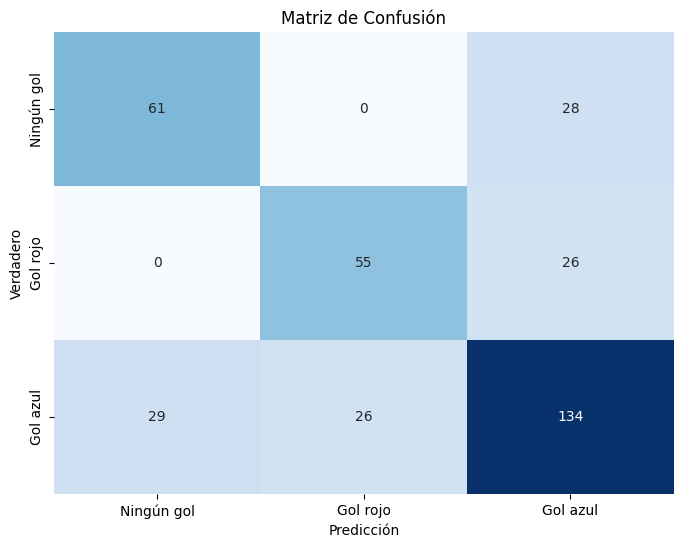

In [120]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Creación de la clave combinada
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)

# Separación de clases para balanceo
indices_nada = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_3_ticks'] == 'none'].index
indices_gol_rojo = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_3_ticks'] == 'Red'].index
indices_gol_azul = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_3_ticks'] == 'Blue'].index

# Determinar la cantidad a muestrear para balancear
num_muestras_gol = min(len(indices_gol_rojo), len(indices_gol_azul))
num_muestras_nada = num_muestras_gol * 2

# Muestreo balanceado de combinaciones match_time
indices_nada_balanceados = resample(indices_nada, n_samples=num_muestras_nada, random_state=42, replace=False)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, n_samples=num_muestras_gol, random_state=42, replace=False)
indices_gol_azul_balanceados = resample(indices_gol_azul, n_samples=num_muestras_gol, random_state=42, replace=False)

# Combinar los índices balanceados
indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])
np.random.shuffle(indices_balanceados)

# Seleccionar los datos balanceados
data_balanceada = data_posiciones_grouped_filtered_labeled.loc[indices_balanceados]

# Construir los vectores de características (X) y etiquetas (y)
X = []
y = []

for row in data_balanceada.itertuples():
    match_time = row.match_time
    gol_3_ticks = row.gol_3_ticks
    
    # Seleccionar las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    if len(subset) == 7:  # Asegurarse de tener las 7 filas
        input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
        X.append(input_data)
        y.append(gol_3_ticks)
    else:
        print(f"Advertencia: {match_time} no tiene 7 filas.")

X = np.array(X)
y = np.array(y)

from collections import Counter
print("Distribución balanceada de clases:", Counter(y))

# Dividir los datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo
from sklearn.neural_network import MLPClassifier
modelo = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=200)

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'],
            yticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


In [122]:
print(X_train[0])
print(y_train)

[ 0.81020593  0.32675227  0.20391817  0.57190672 -1.          0.92043569
  0.47650077  0.19665983  0.52596232  1.          0.61359047  0.61972133
  0.19358383  0.59440198 -1.          0.65928756  0.28091725  0.18563697
  0.48725463  1.          0.85370358  0.43738453  0.18452077  0.53108611
 -1.          0.62353349  0.24711853  0.2054121   0.52807423  1.
  0.92304577  0.41090717  0.20982748  0.56910175  0.        ]
['Red' 'Blue' 'Red' 'Blue' 'Blue' 'Red' 'none' 'Red' 'Red' 'none' 'none'
 'none' 'Blue' 'Blue' 'Blue' 'none' 'none' 'none' 'none' 'none' 'none'
 'Blue' 'none' 'Blue' 'Blue' 'Red' 'none' 'Blue' 'none' 'Blue' 'Blue'
 'Red' 'Red' 'none' 'Red' 'none' 'Red' 'Blue' 'none' 'Red' 'none' 'Red'
 'none' 'Red' 'none' 'Red' 'none' 'Blue' 'Blue' 'Red' 'none' 'Red' 'none'
 'Red' 'none' 'none' 'Blue' 'none' 'none' 'none' 'none' 'none' 'Red'
 'none' 'Red' 'Red' 'none' 'Red' 'Red' 'Red' 'Red' 'none' 'none' 'none'
 'none' 'none' 'none' 'Red' 'none' 'Red' 'Red' 'Red' 'Red' 'none' 'none'
 'Red' 

#### preparacion original

In [123]:
def get_features_for_match_time(match_id, time, data_pos):
    subset = data_pos[(data_pos['match_id'] == match_id) & (data_pos['time'] == time)]
    red_players = subset[subset['team'] == -1][['x', 'y', 'velocity_x', 'velocity_y']].values
    blue_players = subset[subset['team'] == 1][['x', 'y', 'velocity_x', 'velocity_y']].values
    ball = subset[subset['player_id'] == 0][['x', 'y', 'velocity_x', 'velocity_y']].values  # Suponer que la pelota tiene un id específico
    # Ordenar aleatoriamente para asegurar independencia del orden de jugadores
    np.random.shuffle(red_players)
    np.random.shuffle(blue_players)
    return np.concatenate([red_players.flatten(), blue_players.flatten(), ball.flatten()])

In [124]:
# Combinar los IDs para facilitar la búsqueda
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)


In [125]:
# Crear una lista de arrays con las posiciones y velocidades para cada match_time
X = []
y = []

print(data_posiciones_grouped_filtered_labeled)

for row in data_posiciones_grouped_filtered_labeled.itertuples():
    match_time = row.match_time
    gol_3_ticks = row.gol_3_ticks  # Etiqueta objetivo
    
    # Selecciona las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
    
    X.append(input_data)
    y.append(gol_3_ticks)

X = np.array(X)
y = np.array(y)


      match_id        time  entities gol_1_ticks gol_2_ticks gol_3_ticks  \
0           42    0.616667         7        none        none        none   
1           42    1.616667         7        none        none        none   
2           42    2.616667         7        none        none        none   
3           42    3.616667         7        none        none        none   
4           42    4.616667         7        none        none        none   
...        ...         ...       ...         ...         ...         ...   
9568       146  175.266667         7        none        none        none   
9569       146  176.266667         7        none        none        none   
9570       146  177.266667         7        none        none        Blue   
9571       146  178.266667         7        none        Blue        Blue   
9572       146  179.266667         7        Blue        Blue        Blue   

     gol_4_ticks gol_5_ticks gol_6_ticks              match_time  
0           none    

In [126]:
print(X_train[0])
#print(y)

[ 0.41248991  0.71248552  0.18439854  0.62536354 -1.          0.2107438
  0.60784314  0.18414109  0.62677504 -1.          0.7892562   0.5
  0.18258453  0.6276636   1.          0.5459126   0.6362152   0.18388245
  0.6247731   1.          0.53930435  0.57951956  0.18372725  0.62597116
 -1.          0.7892562   0.39215686  0.18399394  0.62584773  1.
  0.40485509  0.87126176  0.18330883  0.62453237  0.        ]


#### Balanceo las clases y muestreo

In [127]:
# Separo las clases
indices_nada = np.where(y == 'none')[0]  # Clase 'sin gol'
indices_gol_rojo = np.where(y == 'Red')[0]  # Clase 'gol del Red'
indices_gol_azul = np.where(y == 'Blue')[0]  # Clase 'gol del Blue'

#print(indices_nada)
#print(indices_gol_rojo)
#print(indices_gol_azul)

# Balanceo las clases y muestreo
from sklearn.utils import resample

# Proporcion 50% nada, 25% gol del Red, 25% gol del Blue
num_muestras_gol = round(min(len(indices_gol_rojo), len(indices_gol_azul))/5)
num_muestras_nada = num_muestras_gol * 2

indices_nada_balanceados = resample(indices_nada, replace=False, n_samples=num_muestras_nada, random_state=8493278)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, replace=False, n_samples=num_muestras_gol, random_state=8493278)
indices_gol_azul_balanceados = resample(indices_gol_azul, replace=False, n_samples=num_muestras_gol, random_state=8493278)

indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])

from sklearn.utils import shuffle
X_balanceado = X[indices_balanceados]
y_balanceado = y[indices_balanceados]
X_balanceado, y_balanceado = shuffle(X_balanceado, y_balanceado, random_state=8493278)

In [128]:
print(X_balanceado)
print(y_balanceado)

[[0.79615497 0.37683523 0.16981827 ... 0.15569417 0.57365649 0.        ]
 [0.38123957 0.810972   0.16683883 ... 0.13064919 0.55961371 0.        ]
 [0.7892562  0.5        0.18399394 ... 0.2275696  0.61158483 0.        ]
 ...
 [0.49806073 0.34934975 0.15844488 ... 0.15438007 0.63037845 0.        ]
 [0.65206746 0.64518467 0.18328442 ... 0.21184212 0.56064402 0.        ]
 [0.65690229 0.55287765 0.18426826 ... 0.20000286 0.70242323 0.        ]]
['none' 'none' 'none' 'none' 'none' 'Red' 'Blue' 'Blue' 'none' 'none'
 'none' 'Red' 'Red' 'Blue' 'none' 'Blue' 'Red' 'Blue' 'none' 'Red' 'Red'
 'Blue' 'none' 'none' 'Blue' 'none' 'Blue' 'none' 'none' 'none' 'Red'
 'none' 'none' 'none' 'Blue' 'Blue' 'none' 'none' 'none' 'none' 'none'
 'Red' 'none' 'none' 'Blue' 'none' 'Red' 'Red' 'Red' 'Red' 'Red' 'none'
 'Red' 'Red' 'none' 'Blue' 'Blue' 'none' 'Red' 'none' 'none' 'Blue' 'none'
 'Blue' 'Blue' 'Blue' 'Blue' 'Red' 'Red' 'Blue' 'Blue' 'none' 'none'
 'none' 'Red' 'Red' 'Blue' 'none' 'none' 'Blue' 'Blue' '

In [129]:
from collections import Counter
print(Counter(y_balanceado))

Counter({'none': 120, 'Red': 60, 'Blue': 60})


#### Entreno el modelo

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size=0.3, random_state=8493278)

# Crear el modelo
modelo = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500)

# Entrenar el modelo
modelo.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500)

In [143]:
print(X_train[0])
print(y)

[ 0.3564175   0.22868618  0.20156429  0.6339028  -1.          0.38317639
  0.70794376  0.19684944  0.62752368 -1.          0.1161021   0.41668384
  0.18164728  0.65233634 -1.          0.34385163  0.30212629  0.18494632
  0.69794176  1.          0.5925615   0.48505096  0.20144511  0.6972939
  1.          0.54361929  0.51320129  0.18468838  0.62766902  1.
  0.27126723  0.07620462  0.17155718  0.58264536  0.        ]
['none' 'none' 'none' ... 'Blue' 'Blue' 'Blue']


In [133]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

  Ningún gol       0.67      0.63      0.65        19
    Gol rojo       0.44      0.44      0.44        18
    Gol azul       0.53      0.54      0.54        35

    accuracy                           0.54        72
   macro avg       0.55      0.54      0.54        72
weighted avg       0.54      0.54      0.54        72

[[12  0  7]
 [ 0  8 10]
 [ 6 10 19]]


              precision    recall  f1-score   support

  Ningún gol       0.47      0.88      0.61         8
    Gol rojo       0.50      0.75      0.60         8
    Gol azul       0.67      0.30      0.41        20

    accuracy                           0.53        36
   macro avg       0.54      0.64      0.54        36
weighted avg       0.59      0.53      0.50        36



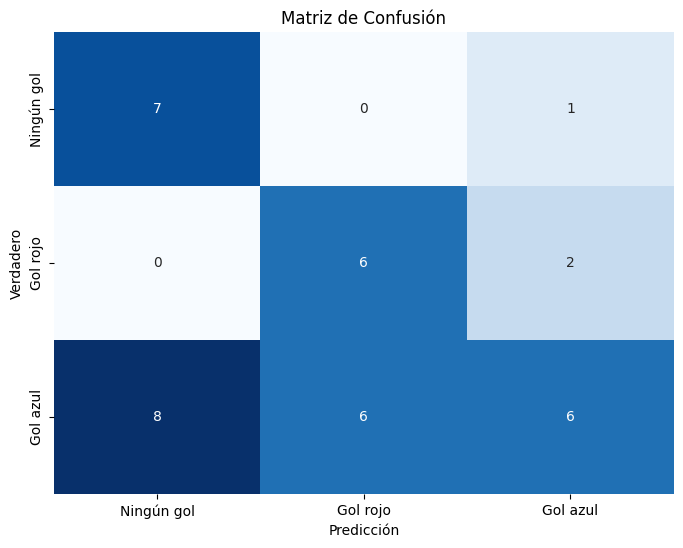


Explicación de la matriz de confusión:
Fila 0: Ningún gol (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul
Fila 1: Gol rojo (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul
Fila 2: Gol azul (Verdadero)
 - Columna 0: Predicho como Ningún gol
 - Columna 1: Predicho como Gol rojo
 - Columna 2: Predicho como Gol azul


In [101]:
# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'],
            yticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Explicación de la matriz
tabla_explicacion = {
    'Filas (Verdadero)': ['Ningún gol', 'Gol rojo', 'Gol azul'],
    'Columnas (Predicción)': ['Ningún gol', 'Gol rojo', 'Gol azul']
}
print("\nExplicación de la matriz de confusión:")
for i, fila in enumerate(tabla_explicacion['Filas (Verdadero)']):
    print(f"Fila {i}: {fila} (Verdadero)")
    print(f" - Columna 0: Predicho como {tabla_explicacion['Columnas (Predicción)'][0]}")
    print(f" - Columna 1: Predicho como {tabla_explicacion['Columnas (Predicción)'][1]}")
    print(f" - Columna 2: Predicho como {tabla_explicacion['Columnas (Predicción)'][2]}")

In [63]:
ejemplo_crudo_test1 = [
-92.56451288707532,	124.45015137068071,	159.4897871523994,	12.686438615544656,	1,
-46.86904236747758,	-82.09417184724326,	162.2066739689642,	3.8808615266944106,	1,
-1.0282322976049685,	-158.42819156230084,138.42971007348893,	20.278973949055498,	1,
-15.400174216859035,	-132.0779034978056,	106.8216737279782,	-14.19809709458249,	2,
369.8938602877177,	-34.44229930738148, 112.5701383585176,	-0.46031655316848,	2,
14.03888309503283,	-126.30365856126663, 123.08482179344048,	-36.63696694933308,	1,
33.03107592831144,	-135.74791243559724,	92.00083312965478,	68.79246629432616,	0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo_test1[i:i + 5] for i in range(0, len(ejemplo_crudo_test1), 5)], columns=columns)

data_test1_normalizada = normalizar_datos(data_test1)
print(data_test1_normalizada)

          x         y  velocity_x  velocity_y  team
0  0.000000  1.000000    0.961301    0.467833    -1
1  0.098810  0.269848    1.000000    0.384312    -1
2  0.197934  0.000000    0.661325    0.539849    -1
3  0.166857  0.093151    0.211106    0.212833     1
4  1.000000  0.438301    0.292986    0.343136     1
5  0.230515  0.113563    0.442755    0.000000    -1
6  0.271582  0.080177    0.000000    1.000000     0


### ...etc... (no correr)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Salida para 3 clases: ninguno, gol rojo, gol azul
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
history = model.fit(X, y.argmax(axis=1), epochs=50, batch_size=32, validation_split=0.2)


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
loss, accuracy = model.evaluate(X, y.argmax(axis=1))
print(f"Loss: {loss}, Accuracy: {accuracy}")


In [ ]:
# Predecir probabilidades para cada entrada
predicciones_probabilidades = model.predict(X)

# Convertir las probabilidades en clases (0, 1, 2)
predicciones_clases = predicciones_probabilidades.argmax(axis=1)


In [ ]:
import pandas as pd

# Crear un DataFrame para analizar
resultados = pd.DataFrame({
    'match_id': data_posiciones_grouped_filtered_labeled['match_id'],
    'time': data_posiciones_grouped_filtered_labeled['time'],
    'prediccion_clase': predicciones_clases,
    'gol_verdadero': y.argmax(axis=1),  # Convertir las etiquetas verdaderas en la misma forma
    'prob_nada': predicciones_probabilidades[:, 0],
    'prob_gol_rojo': predicciones_probabilidades[:, 1],
    'prob_gol_azul': predicciones_probabilidades[:, 2],
})

# Mostrar los primeros resultados
print(resultados.sample(10))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar un informe de clasificación
print(classification_report(y.argmax(axis=1), predicciones_clases, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y.argmax(axis=1), predicciones_clases))
